In [1]:
using BSON
using DataFrames
using Distributions
using CSV
using Flux
using HDF5
using Plots
using StatsPlots
using Statistics

In [2]:
include("ActiveLearning.jl")
include("DataSets.jl")
using .ActiveLearning
using .DataSets

In [3]:
X_mnist_train, y_mnist_train, X_mnist_test, y_mnist_test = prepare_mnist(get_mnist("data/mnist"))
size(X_mnist_train), size(X_mnist_test)

((32, 32, 1, 60000), (32, 32, 1, 10000))

In [4]:
random_df = DataFrame(CSV.File("data/random-sampling.csv"))
random_gdf = groupby(random_df, :round)
accuracies_mean_random = combine(random_gdf, :accuracy => mean).accuracy_mean
accuracies_std_random = combine(random_gdf, :accuracy => std).accuracy_std
size(accuracies_mean_random), size(accuracies_std_random)

((31,), (31,))

In [5]:
entropy_df = DataFrame(CSV.File("data/entropy-sampling.csv"))
entropy_gdf = groupby(entropy_df, :round)
accuracies_mean_entropy = combine(entropy_gdf, :accuracy => mean).accuracy_mean
accuracies_std_entropy = combine(entropy_gdf, :accuracy => std).accuracy_std
size(accuracies_mean_entropy), size(accuracies_std_entropy)

((31,), (31,))

In [6]:
n = 30
confidence_level = 0.99
α = 1 - confidence_level
t = cquantile(TDist(n - 1), α / 2)

2.756385903670605

In [7]:
confidence_interval_random = t * (accuracies_std_random / sqrt(n))

31-element Vector{Float64}:
 5.682654486178459e-17
 0.024100721842484938
 0.021839010419215734
 0.015997984017781974
 0.012620663614605895
 0.011885310219650965
 0.01023151060445844
 0.009747550941900104
 0.009843552221487516
 0.005915854999396449
 0.0055715070881080875
 0.0047345928862242365
 0.004318176129247981
 ⋮
 0.0026791086371311837
 0.0024789190231345373
 0.002323276318334602
 0.0023161215258668396
 0.0017261593080375266
 0.0017433883600345196
 0.0017360930879695214
 0.0018174440897318134
 0.0018064166344438865
 0.002047858347425664
 0.001715593765575049
 0.002441595497682174

In [8]:
confidence_interval_entropy = t * (accuracies_std_entropy / sqrt(n))

31-element Vector{Float64}:
 5.682654486178459e-17
 0.0079319211523603
 0.019424249628090768
 0.020874186960593868
 0.02325420403712854
 0.02070889069747847
 0.01809814353015645
 0.018423825568905042
 0.01598835246877792
 0.01587216441330276
 0.011595714481920552
 0.00903959271288463
 0.007373178269862871
 ⋮
 0.0030163872121164643
 0.002427764422820198
 0.002261801997900648
 0.002142833770982577
 0.0018089191218861641
 0.0018061531402549368
 0.0017258177797725078
 0.0015259872903787487
 0.0015612818745887717
 0.0016728166179731082
 0.0016935432580943294
 0.0013742841127986822

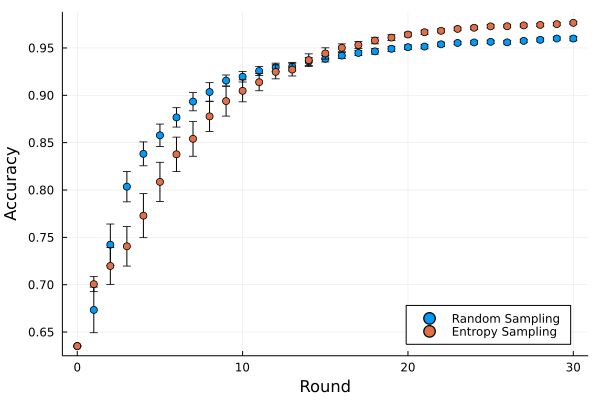

In [9]:
scatter(0:30, accuracies_mean_random, yerror=confidence_interval_random,
    label="Random Sampling",
    legend_position=:bottomright, xlabel="Round", ylabel="Accuracy")
scatter!(0:30, accuracies_mean_entropy, yerror=confidence_interval_entropy,
    label="Entropy Sampling")

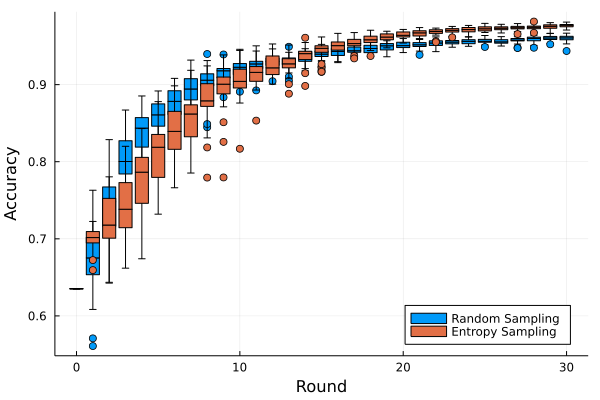

In [10]:
@df random_df boxplot(:round, :accuracy, label="Random Sampling",
    legend_position=:bottomright, xlabel="Round", ylabel="Accuracy")
@df entropy_df boxplot!(:round, :accuracy, label="Entropy Sampling")

In [ ]:
file = "data/human_labeller.hdf5"
h5open(file, "w") do datafile
    write(datafile, "X", X_mnist_train)
    write(datafile, "y", y_mnist_train)
end

function human_labeller_wrap(index_query, prob_query, round)
    human_labeller(index_query, prob_query, round, y_mnist_train, file)
end 

rounds_human, accuracies_human = simulate_al(
    entropy_sampling, human_labeller_wrap,
    BSON.load("lenet.bson")[:model],
    X_mnist_train, y_mnist_train,
    X_mnist_test, y_mnist_test,
    n_query=100)